In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("슝=3")

슝=3


# Step1. 데이터 수집하기
---

In [2]:
# 챗봇 데어티(KOR) 렁크
# https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv
chatbot_data = pd.read_csv('ChatbotData.csv')
display(chatbot_data.head())
# 기존 노드와는 다른 형태의 데이터이므로 기존 노드에서 제시한 데이터와 비슷한 형태로 변경해준다.
# label은 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링되는데 여기서는 사용하지 않는다.
questions_arr = chatbot_data['Q'].values
answers_arr = chatbot_data['A'].values

print(questions_arr)
print(answers_arr)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


['12시 땡!' '1지망 학교 떨어졌어' '3박4일 놀러가고 싶다' ... '흑기사 해주는 짝남.'
 '힘든 연애 좋은 연애라는게 무슨 차이일까?' '힘들어서 결혼할까봐']
['하루가 또 가네요.' '위로해 드립니다.' '여행은 언제나 좋죠.' ... '설렜겠어요.'
 '잘 헤어질 수 있는 사이 여부인 거 같아요.' '도피성 결혼은 하지 않길 바라요.']


# Step2. 데이터 전처리하기
---

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있다.

In [3]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    #sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
print("슝=3")

슝=3


영어 데이터와 형식이 달라 질문과 답변 데이터셋 구성하기 위한 함수(load_conversations)를 수정하였다.

In [4]:
def load_conversations():
    inputs, outputs = [], []
    
    for i in questions_arr:
        inputs.append(preprocess_sentence(i))
        
    for i in answers_arr:
        outputs.append(preprocess_sentence(i))
        
    return inputs, outputs
print("슝=3")

슝=3


질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해보자.(실제 데이터와 확인해보면 좀더 명확힐 파악할 수 있다.)

In [5]:
questions, answers = load_conversations()

print('Q : ', questions[32])
print('A : ', answers[32])

print('Q : ', questions[20])
print('A : ', answers[20])

Q :  가족들이랑 어디 가지 ?
A :  온 가족이 모두 마음에 드는 곳으로 가보세요 .
Q :  가스비 비싼데 감기 걸리겠어
A :  따뜻하게 사세요 !


# Step3. SubwordTextEncoder 사용하기
---

* **작업 진행 순서**
    * TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.   
    단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.
    * 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
    * 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
    * MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

## 단어장 만들기

In [6]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13) #Tensorflow 2.2.0 이하 버전
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여 정수를 부여해준다.   
기존 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기보다 1이 큰 수를 번호로 부여하자.

In [7]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여하자.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]
print('START_TOKEN의 번호 : ', [tokenizer.vocab_size])
print('END_TOKEN의 번호 : ', [tokenizer.vocab_size+1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정하자.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 :  [8170]
END_TOKEN의 번호 :  [8171]
8172


## 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

tensorflow_datasets의 SubwordTextEncoder를 사용해 tokenizer를 정의하고 단어장을 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수시퀀스를 단어 시퀀스로 변환할 수 있다.

In [8]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환

print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5761, 610, 2490, 4163]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7510, 7, 6273, 97, 1]


In [9]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]

print('Questions 최대 길이 : {}'.format(np.max(questions_len)))
print('Answers 최대 길이 : {}'.format(np.max(answers_len)))

Questions 최대 길이 : 16
Answers 최대 길이 : 24


질문과 답변 셋에 대해서 전부 정수 인코딩을 수행하고 문장의 최대 길이 및 해당 최대 길이로 패딩한다.

In [10]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 24

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 24 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 24 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


정수 인코딩 과정을 수행하면서 샘플의 길이를 40으로 제한하였지만 해당 데이터에는 샘플의 길이가 40이 넘는 데이터가 없으므로 길이가 유지되었다.

In [11]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11815
필터링 후의 답변 샘플 개수: 11815


## 교사 강요(Teacher Forcing)사용하기

교사 강요(teacher forcing)란, 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법이다.

훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용한다.

[위키독스 https://wikidocs.net/46496](https://wikidocs.net/46496)

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# Step4. 모델 구성하기
---

## 포지셔널 인코딩 레이어

이전 실습 과정등을 통해 모델을 구성해보자.   
트랜스포머는 단어를 한개씩 순차적으로 받는게 아니라 문장에 있는 단어 전체를 한꺼번에 입력으로 받기 때문에 각 단어가 문장의 몇번째 어순으로 입력되었는지를 모델에 추가로 알려주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터값을 더해서 모델의 입력으로 한다.   
포지셔널 인코딩층을 만들어보자.

In [13]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
      # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
         # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

         # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


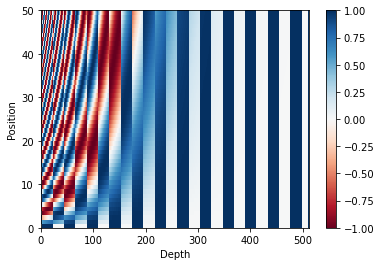

In [14]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 스케일드 닷 프로덕트 어텐션

단어들 간의 유사도를 구하는 메커니즘을 어텐션이라 한다. 어텐션 함수는 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 값에 반영해준다. 이 유사도가 반영된 값을 모두 더해주면 어텐션 값을 구할 수 있다.
내적을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구한 것이다.

In [15]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax 적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


## 멀티 헤드 어텐션

어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라 부른다.

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
    
print("슝=3")

슝=3


## 마스킹

마스킹이란 특정 값들을 가려 실제 연산에 방해가 되지 않도록 하는 기법이다.   
트랜스포머에서는 2가지를 사용한다.

* 패딩 마스킹
  * 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주기 위해 정해진 길이보다 짧은 문장은 숫자 0 을 채워서 문장의 길이를 맞춰준다.
* 룩 어헤드 마스킹(다음 단어 가리기)
  * 트랜스포머 같은 경우 한번에 한 단어가 아닌 한 문장이 입력으로 사용 되기 때문에 decoder층에서 위치와 상관없이 모든 단어를 참고에서 다음 단어를 예측할 수 있다.   
    (우리는 이전 단어들을 바탕으로 다음 단어를 예측해야 한다!)
  * 그걸 막기 위해 사용한다.

In [17]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [18]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


## 인코더

하나의 인코더 층은 총 2개의 서브층으로 나누어 진다.   
바로 셀프 어텐션과 피드 포워드 신경망이다.

In [19]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


임베딩 층과 포지셔널 인코딩을 연결하고, 사용자가 원하는 만큼(num_layers) 인코더 층을 쌓음으로써 트랜스 포머의 인코더가 완성된다.

In [20]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers 만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

print("슝=3")

슝=3


## 디코더

디코더는 세 개의 서브층으로 구성된다.   
셀프 어텐션, 인코더-디코더 어텐션 두개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행한다.

In [21]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


디코더 층은 임베딩 층과 포지셔널 인코딩을 연결하고, 사용자가 원하는 만큼(num_layers) 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

In [22]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


## Transformer
인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의한다.

In [23]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
      )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
      )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## 모델 생성

논문에서는 num_layers는 6, d-Model은 512을 사용하였지만 빠르고 원활한 훈련을 위해 여기에서는 보다 작은 값을 사용한다.

In [24]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실 함수

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 떄 패딩 마스크를 적용해야 한다.

In [25]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print("슝=3")

슝=3


## 커스텀 된 학습률(Learning rate)

커스텀 된 학습률이란 모델 학습 초기에 Learning rete를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

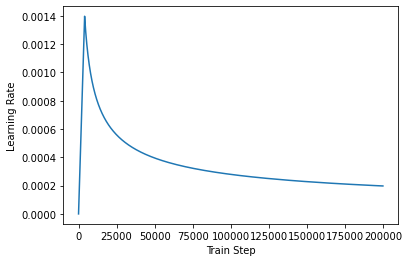

In [27]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

손실 함수와 커스텀 된 학습률을 사용하여 모델을 컴파일한다.

In [28]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


## 모델 훈련

In [29]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 183s 930ms/step - loss: 2.4503 - accuracy: 0.0523
Epoch 2/20
185/185 [==============================] - 146s 792ms/step - loss: 1.9830 - accuracy: 0.0840
Epoch 3/20
185/185 [==============================] - 143s 775ms/step - loss: 1.6922 - accuracy: 0.0856
Epoch 4/20
185/185 [==============================] - 143s 770ms/step - loss: 1.5670 - accuracy: 0.0920
Epoch 5/20
185/185 [==============================] - 136s 737ms/step - loss: 1.4693 - accuracy: 0.0979
Epoch 6/20
185/185 [==============================] - 138s 744ms/step - loss: 1.3709 - accuracy: 0.1044
Epoch 7/20
185/185 [==============================] - 135s 730ms/step - loss: 1.2604 - accuracy: 0.1145
Epoch 8/20
185/185 [==============================] - 112s 607ms/step - loss: 1.1393 - accuracy: 0.1275
Epoch 9/20
185/185 [==============================] - 123s 663ms/step - loss: 1.0050 - accuracy: 0.1421
Epoch 10/20
185/185 [==============================] - 134s 722m

# Step5. 모델 평가하기
---

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위 과정을 포함한 decoder_inference 함수를 만든다.

In [30]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [44]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    print('-'*30)
    return predicted_sentence
print("슝=3")

슝=3


In [57]:
 sentence_generation('이름이 뭐야?')

입력 : 이름이 뭐야?
출력 : 위로봇이요 .
------------------------------


'위로봇이요 .'

In [59]:
 sentence_generation('기분이 어때?')

입력 : 기분이 어때?
출력 : 한 번 떠난 마음은 쉽게 돌아오지 않나봐요 .
------------------------------


'한 번 떠난 마음은 쉽게 돌아오지 않나봐요 .'

In [46]:
 sentence_generation('안녕?')

입력 : 안녕?
출력 : 안녕하세요 .
------------------------------


'안녕하세요 .'

In [47]:
 sentence_generation('속상해')

입력 : 속상해
출력 : 기분전환을 해보세요 .
------------------------------


'기분전환을 해보세요 .'

In [48]:
 sentence_generation('배고파')

입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .
------------------------------


'뭐 좀 챙겨드세요 .'

In [49]:
 sentence_generation('뭐해?')

입력 : 뭐해?
출력 : 장 보러 갈 타이밍이네요 .
------------------------------


'장 보러 갈 타이밍이네요 .'

In [50]:
 sentence_generation('기분이 어때?')

입력 : 기분이 어때?
출력 : 한 번 떠난 마음은 쉽게 돌아오지 않나봐요 .
------------------------------


'한 번 떠난 마음은 쉽게 돌아오지 않나봐요 .'

In [60]:
 sentence_generation('신난다')

입력 : 신난다
출력 : 심호흡해보세요 .
------------------------------


'심호흡해보세요 .'

In [55]:
 sentence_generation('우울하다')

입력 : 우울하다
출력 : 함께 충분한 대화를 하고 상담을 받아보는 게 좋겠어요 .
------------------------------


'함께 충분한 대화를 하고 상담을 받아보는 게 좋겠어요 .'

# 회고
---
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

이번 프로젝트에서 어려웠던 점은 Transformer에 대한 개념의 이해와 코드상 에러였다. 개념 이해랄 하기위해 블로그 및 영상자료를 보고 이해하도록 노력하였다. 코드상의 에러는 결과물이 계속 똑같은 대답만 출력하는 이슈가 있었는데 이 부분에 대한 이슈의 원인을 찾는데 많은 시간을 쏟았던 것 같다.(결론은 아주 사소한 오타...)   
프로젝트를 진행하면서 알아낸 점은 Transformer의 개념 이해이다. 위에서 말한것 처럼 블로그 및 영상 자료로 이해하려고 노력하였다.    
하지만 아직도 부분 부분 이해가 덜 된 부분이 있어 소스를 보면서 좀 더 개념 정리를 하도록 노력해야 될 것 같다.